In [187]:
# !pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
from collections import Counter
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
train_data = pd.read_csv(r'train_final.csv')
test_data = pd.read_csv(r'test_final.csv')

训练集和测试集的大小都为50000个样本，146个特征，其中都包含目标 `loan_status`

In [3]:
print("train data size: ", train_data.shape)
print("test data size: ", test_data.shape)

train data size:  (50000, 146)
test data size:  (50000, 146)


In [4]:
train_data['loan_status'].head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 146 entries, continuous_annual_inc to discrete_term_2_one_hot
dtypes: float64(20), int64(126)
memory usage: 55.7 MB


In [77]:
# [idx for idx in train_data.columns if train_data[idx].dtype == np.float64]

## 缺失值研究

In [7]:
train_data.isnull().sum().sort_values(ascending=False)[:10]

continuous_annual_inc_joint               49780
continuous_dti_joint                      49780
continuous_mths_since_last_record         40505
continuous_mths_since_last_major_derog    34948
continuous_mths_since_last_delinq         23917
continuous_dti                                1
discrete_addr_state_29_one_hot                0
discrete_addr_state_34_one_hot                0
discrete_addr_state_33_one_hot                0
discrete_addr_state_32_one_hot                0
dtype: int64

In [8]:
sum(train_data['continuous_annual_inc_joint'].isnull() & train_data['loan_status'] == 1) / sum(train_data['continuous_annual_inc_joint'].isnull()),\
sum(train_data['continuous_annual_inc_joint'].notnull() & train_data['loan_status'] == 1) / sum(train_data['continuous_annual_inc_joint'].notnull())

(0.7960024106066693, 0.740909090909091)

In [9]:
sum(train_data['continuous_dti_joint'].isnull() & train_data['loan_status'] == 1)/sum(train_data['continuous_dti_joint'].isnull()),\
sum(train_data['continuous_dti_joint'].notnull() & train_data['loan_status'] == 1)/sum(train_data['continuous_dti_joint'].notnull())

(0.7960024106066693, 0.740909090909091)

In [10]:
record = sum(train_data['continuous_mths_since_last_record'].isnull())
TP = sum(train_data['continuous_mths_since_last_record'].isnull() & train_data['loan_status'] == 1)
precision = TP / sum(train_data['continuous_mths_since_last_record'].isnull())
recall = TP / sum(train_data['loan_status'] == 1)
2 * precision * recall / (precision + recall)

0.8095848953208872

In [11]:
sum(train_data['continuous_mths_since_last_record'].isnull() & train_data['loan_status'] == 1) / sum(train_data['continuous_mths_since_last_record'].isnull()),\
sum(train_data['continuous_mths_since_last_record'].notnull() & train_data['loan_status'] == 1) / sum(train_data['continuous_mths_since_last_record'].notnull())

(0.8024194543883472, 0.7673512374934176)

In [12]:
major_derog = sum(train_data['continuous_mths_since_last_major_derog'].isnull())
major_derog_loan = sum(train_data['continuous_mths_since_last_major_derog'].isnull() & train_data['loan_status'] == 1)
major_derog, major_derog_loan, major_derog_loan / major_derog

(34948, 28055, 0.802764106672771)

<AxesSubplot:xlabel='continuous_mths_since_last_major_derog', ylabel='Count'>

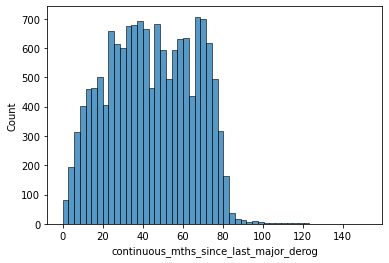

In [13]:
sns.histplot(train_data['continuous_mths_since_last_major_derog'])

In [14]:
delinq = sum(train_data['continuous_mths_since_last_delinq'].isnull())
delinq_loan = sum(train_data['continuous_mths_since_last_delinq'].isnull() & train_data['loan_status'] == 1)
delinq, delinq_loan, delinq_loan / delinq

(23917, 19200, 0.8027762679265794)

<AxesSubplot:xlabel='continuous_mths_since_last_delinq', ylabel='Count'>

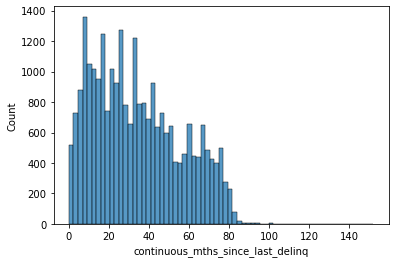

In [15]:
sns.histplot(train_data['continuous_mths_since_last_delinq'])

## 缺失值处理

- `continuous_dti`只有一个缺失值，用该特征平均值填充
- `continuous_annual_inc_joint`与`continuous_dti_joint`几乎没有非null值，并且已有类似的特征在数据集里，所以直接除去
- 其余几个特征缺失值太多，考虑将其一一转化成是否为null的binary特征

In [16]:
train_data.fillna(value={'continuous_dti': train_data['continuous_dti'].mean()}, inplace=True)
train_data['continuous_mths_since_last_record_isnull'] = train_data['continuous_mths_since_last_record'].isnull()
train_data['continuous_mths_since_last_major_derog_isnull'] = train_data['continuous_mths_since_last_major_derog'].isnull()
train_data['continuous_mths_since_last_delinq_isnull'] = train_data['continuous_mths_since_last_delinq'].isnull()
train_data.drop(columns=['continuous_annual_inc_joint',
                         'continuous_dti_joint',
                         'continuous_mths_since_last_record',
                         'continuous_mths_since_last_major_derog',
                         'continuous_mths_since_last_delinq'], inplace=True)

In [17]:
test_data.fillna(value={'continuous_dti': test_data['continuous_dti'].mean()}, inplace=True)
test_data['continuous_mths_since_last_record_isnull'] = test_data['continuous_mths_since_last_record'].isnull()
test_data['continuous_mths_since_last_major_derog_isnull'] = test_data['continuous_mths_since_last_major_derog'].isnull()
test_data['continuous_mths_since_last_delinq_isnull'] = test_data['continuous_mths_since_last_delinq'].isnull()
test_data.drop(columns=['continuous_annual_inc_joint',
                        'continuous_dti_joint',
                        'continuous_mths_since_last_record',
                        'continuous_mths_since_last_major_derog',
                        'continuous_mths_since_last_delinq'], inplace=True)

In [18]:
train_data.isnull().sum().sort_values(ascending=False)[:5]

continuous_mths_since_last_delinq_isnull         0
continuous_mths_since_last_major_derog_isnull    0
discrete_addr_state_36_one_hot                   0
discrete_addr_state_35_one_hot                   0
discrete_addr_state_34_one_hot                   0
dtype: int64

In [19]:
train_data.columns

Index(['continuous_annual_inc', 'continuous_delinq_2yrs', 'continuous_dti',
       'continuous_fico_range_high', 'continuous_fico_range_low',
       'continuous_funded_amnt', 'continuous_funded_amnt_inv',
       'continuous_inq_last_6mths', 'continuous_installment',
       'continuous_int_rate',
       ...
       'discrete_sub_grade_31_one_hot', 'discrete_sub_grade_32_one_hot',
       'discrete_sub_grade_33_one_hot', 'discrete_sub_grade_34_one_hot',
       'discrete_sub_grade_35_one_hot', 'discrete_term_1_one_hot',
       'discrete_term_2_one_hot', 'continuous_mths_since_last_record_isnull',
       'continuous_mths_since_last_major_derog_isnull',
       'continuous_mths_since_last_delinq_isnull'],
      dtype='object', length=144)

## 数据集标签平衡性
可以看到训练集的标签类别是分布不平衡的，`loan_status`为0的有大约10000个样本，为1的大约有40000个样本。考虑对样本不平衡进行处理。(采用SMOTE进行过采样，效果并无显著提升，最后没有处理，直接用原数据)

<AxesSubplot:xlabel='loan_status', ylabel='count'>

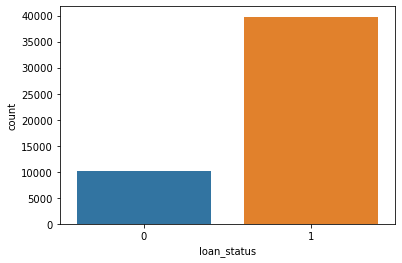

In [20]:
sns.countplot(x='loan_status', data=train_data)

<AxesSubplot:xlabel='loan_status', ylabel='count'>

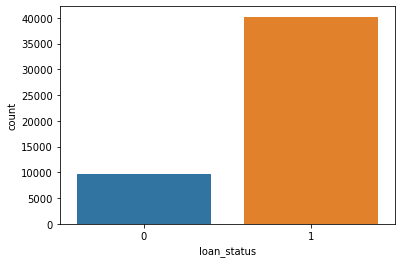

In [21]:
sns.countplot(x='loan_status', data=test_data)

## 关于one hot特征

一开始考虑到lightgbm其中一个特点是可以直接处理类别型特征：

```
LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up).
```

而数据集里显然已经把所有类别型特征给转化成独热向量了；曾经尝试过通过以下几段注释掉的代码将独热向量反向转化为类别型特征，用整型代表，然后输入到模型里；但是表现并没有显著变化，所以最后放弃这部分处理。

In [22]:
# one_hots = [idx for idx in train_data.columns if 'one_hot' in idx]
# one_hot_dict = {}
# for string in one_hots:
#     string = string[:-8]
#     n = int(string.split('_')[-1])
#     s = '_'.join(string.split('_')[:-1])
#     if s not in one_hot_dict.keys():
#         one_hot_dict[s] = n
#     else:
#         one_hot_dict[s] = max(one_hot_dict[s], n)
# one_hot_dict

{'discrete_addr_state': 49,
 'discrete_application_type': 2,
 'discrete_emp_length': 12,
 'discrete_grade': 7,
 'discrete_home_ownership': 4,
 'discrete_policy_code': 1,
 'discrete_purpose': 12,
 'discrete_pymnt_plan': 1,
 'discrete_sub_grade': 35,
 'discrete_term': 2}

In [105]:
# def helperOneHot(train_data, s, n):
#     for i in range(train_data.shape[0]):
#         for k in range(1, n + 1):
#             if train_data.loc[i, '{}_{}_one_hot'.format(s, k)] == 1:
#                 train_data.loc[i, s] = int(k)
#                 break
#     return train_data.astype({s: 'int64'})

# train_data_no_oh = train_data
# test_data_no_oh = test_data
# for s, n in one_hot_dict.items():
#     train_data_no_oh = helperOneHot(train_data_no_oh, s, n)
#     test_data_no_oh = helperOneHot(test_data_no_oh, s, n)

# for s in one_hot_dict.keys():
#     cols = ['{}_{}_one_hot'.format(s, i) for i in range(1, one_hot_dict[s] + 1)]
#     train_data_no_oh.drop(columns=cols, inplace=True)
#     test_data_no_oh.drop(columns=cols, inplace=True)

## 训练集与验证集的划分

In [106]:
# X_train_no_oh, y_train_no_oh = train_data_no_oh.drop(columns='loan_status'), train_data_no_oh['loan_status']
# print(X_train_no_oh.shape, y_train_no_oh.shape)

# X_test_no_oh, y_test_no_oh = test_data_no_oh.drop(columns='loan_status'), test_data_no_oh['loan_status']
# print(X_test_no_oh.shape, y_test_no_oh.shape)

(50000, 28) (50000,)
(50000, 28) (50000,)


In [107]:
# counter = Counter(y_train)
# print(counter)
# # # transform the dataset
# oversample = SMOTE()
# X_train_smote, y_train_smote = oversample.fit_resample(X_train_no_oh, y_train_no_oh)
# counter = Counter(y_train_smote)
# print(counter)

Counter({0: 20387, 1: 20358})
Counter({1: 39788, 0: 39788})


最后使用 `lgb.cv` 以及 `GridSearchCV` 去进行调参，并没有人为划分训练集和验证集

In [78]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_no_oh, y_train_no_oh, test_size=0.1, stratify=y_train_no_oh)
# X_train, X_val, y_train, y_val = train_test_split(X_train_no_oh, y_train_no_oh, test_size=0.1)
# X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns='loan_status'), train_data['loan_status'], test_size=0.1)
# X_train, X_val, y_train, y_val = train_test_split(X_train_smote, y_train_smote, test_size=0.2, stratify=y_train_smote)

# print(X_train.head())
print(X_train.shape, X_val.shape)

(45000, 143) (5000, 143)


先把整个训练数据转化成 `lgb.Dataset` 格式，然后输入到模型中，使用以下初始化参数

In [53]:
# 使用 lgb.Dataset 格式
# train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=list(one_hot_dict.keys()), free_raw_data=False)
# validation_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=list(one_hot_dict.keys()), free_raw_data=False)
data_lgb = lgb.Dataset(train_data.drop(columns='loan_status'), label=train_data['loan_status'], free_raw_data=False)
train_lgb = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
validation_lgb = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

# 初始参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'metric': 'auc',
    'num_iterations': 1000,
    'num_leaves': 20,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

用 `lgb.cv` 进行调参，得到 `n_estimators` 的最优值为 83

In [54]:
# 模型训练
# gbm = lgb.train(params, train_lgb, valid_sets=[validation_lgb])


cv_results = lgb.cv(params, data_lgb, num_boost_round=1000, nfold=5, stratified=False, shuffle=True, metrics='auc', early_stopping_rounds=50, seed=0)
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

C:\Users\Jack\miniconda3\envs\datascience\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 31856, number of negative: 8144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 139
[LightGBM] [Info] Number of positive: 31852, number of negative: 8148
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 139
[LightGBM] [Info] Number of positive: 31795, number of negative: 8205
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

best `n_estimators` value is 83

得到 `n_estimators` 的最优值后，开始进行第一轮网格搜索调参，第一轮的参数为 `max_depth` 和 `num_leaves`；得到的最优值分别为 4 和 10

In [56]:
paramTest1 = {'max_depth': range(2, 10, 1), 'num_leaves': range(5, 100, 5)}

gsearch1 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1,
                                                       n_estimators=83,
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8),
                        param_grid=paramTest1, scoring='roc_auc', cv=5, n_jobs=-1)
gsearch1.fit(train_data.drop(columns='loan_status'), train_data['loan_status'])
gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['mean_test_score'].mean()

(array([0.96068497, 0.96068497, 0.96068497, 0.96068497, 0.96068497,
        0.96068497, 0.96068497, 0.96068497, 0.96068497, 0.96068497,
        0.96068497, 0.96068497, 0.96068497, 0.96068497, 0.96068497,
        0.96068497, 0.96068497, 0.96068497, 0.96068497, 0.96082095,
        0.96103586, 0.96103586, 0.96103586, 0.96103586, 0.96103586,
        0.96103586, 0.96103586, 0.96103586, 0.96103586, 0.96103586,
        0.96103586, 0.96103586, 0.96103586, 0.96103586, 0.96103586,
        0.96103586, 0.96103586, 0.96103586, 0.96089721, 0.96111723,
        0.96088435, 0.96092834, 0.96092834, 0.96092834, 0.96092834,
        0.96092834, 0.96092834, 0.96092834, 0.96092834, 0.96092834,
        0.96092834, 0.96092834, 0.96092834, 0.96092834, 0.96092834,
        0.96092834, 0.96092834, 0.96089721, 0.96094652, 0.9609954 ,
        0.96082558, 0.96060316, 0.96056288, 0.96044602, 0.96044602,
        0.96044602, 0.96044602, 0.96044602, 0.96044602, 0.96044602,
        0.96044602, 0.96044602, 0.96044602, 0.96

In [57]:
clf1 = gsearch1.best_estimator_
clf1

LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, max_depth=4,
               metrics='auc', n_estimators=83, num_leaves=10,
               objective='binary')

optimal value for `max_depth` is 4 and optimal value for `num_leaves` is 10.

看一下第一轮过后的表现，准确率 `accuracy` 为 0.91764，`roc_auc` 为 0.875699 

In [58]:
def results(clf, data):
    y_pred = clf.predict(data.drop(columns='loan_status'))
    y_pred = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred)))
    y = data['loan_status']
    return {'accuracy': accuracy_score(y, y_pred),
            'roc_auc': roc_auc_score(y, y_pred)}

results(clf1, test_data)

{'accuracy': 0.91764, 'roc_auc': 0.8756988382937406}

现在开始进行第二轮网格搜索调参，第二轮的参数为 `min_data_in_leaf`；得到的最优值为 140

In [59]:
paramTest2 = {'min_data_in_leaf': range(5, 155, 5)}

gsearch2 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1,
                                                       n_estimators=82,
                                                       max_depth=4,
                                                       num_leaves=10,
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8),
                        param_grid=paramTest2, scoring='roc_auc', cv=5, n_jobs=-1)
gsearch2.fit(X_train,y_train)
gsearch2.cv_results_['mean_test_score'], gsearch2.cv_results_['mean_test_score'].mean()

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


(array([0.96059155, 0.96057467, 0.96053096, 0.96057324, 0.96055448,
        0.96055347, 0.96061442, 0.96056771, 0.9606309 , 0.96072561,
        0.96068197, 0.96066348, 0.96071941, 0.9607305 , 0.96061674,
        0.96058627, 0.96060219, 0.96053595, 0.96059588, 0.96066609,
        0.9606667 , 0.96071893, 0.96077546, 0.96059836, 0.96064973,
        0.96074422, 0.96067689, 0.96078756, 0.96063708, 0.96052441]),
 0.9606364933221986)

In [60]:
gsearch2.best_params_

{'min_data_in_leaf': 140}

In [61]:
clf2 = gsearch2.best_estimator_
clf2

LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, max_depth=4,
               metrics='auc', min_data_in_leaf=140, n_estimators=82,
               num_leaves=10, objective='binary')

第二轮过后的表现如下

In [62]:
results(clf2, test_data)

{'accuracy': 0.91762, 'roc_auc': 0.8753765976682328}

第三轮调参的对象是防止过拟合的参数： `lambda_l1` 以及 `lambda_l2`

In [63]:
paramTest3 = {'lambda_l1': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
              'lambda_l2': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

gsearch3 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt',
                                                       objective='binary',
                                                       metrics='auc',
                                                       learning_rate=0.1,
                                                       n_estimators=82,
                                                       min_data_in_leaf=140,
                                                       max_depth=4,
                                                       num_leaves=10,
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8),
                        param_grid=paramTest3, scoring='roc_auc', cv=5, n_jobs=-1)
gsearch3.fit(X_train,y_train)
gsearch3.cv_results_['mean_test_score'], gsearch3.cv_results_['mean_test_score'].mean()

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001


(array([0.96078755, 0.96078753, 0.96062171, 0.96078756, 0.96062171,
        0.96062813, 0.96063375, 0.9606609 , 0.96061072, 0.96056447,
        0.96077298, 0.96080488, 0.96060907, 0.96077296, 0.96060907,
        0.96062493, 0.96063252, 0.96067345, 0.96059741, 0.9605999 ,
        0.96063565, 0.96061885, 0.96070876, 0.96063565, 0.96070876,
        0.96069257, 0.96062434, 0.96061176, 0.96060351, 0.96067026,
        0.96078756, 0.96078753, 0.96062171, 0.96078756, 0.96062171,
        0.96062813, 0.96063374, 0.96066087, 0.96061072, 0.96056447,
        0.96063565, 0.96061885, 0.96070876, 0.96063565, 0.96070876,
        0.96069257, 0.96062434, 0.96061176, 0.96060351, 0.96067026,
        0.96065666, 0.96065662, 0.96069431, 0.96065666, 0.96069431,
        0.96055566, 0.96072729, 0.96076221, 0.96072778, 0.9606771 ,
        0.96061636, 0.96061637, 0.96061122, 0.96061634, 0.96061122,
        0.96058555, 0.96070384, 0.96062638, 0.96061826, 0.96062976,
        0.96076249, 0.96076236, 0.96075459, 0.96

In [64]:
gsearch3.best_params_

{'lambda_l1': 0.001, 'lambda_l2': 0.001}

In [65]:
clf3 = gsearch3.best_estimator_
clf3

LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=0.001,
               lambda_l2=0.001, max_depth=4, metrics='auc',
               min_data_in_leaf=140, n_estimators=82, num_leaves=10,
               objective='binary')

In [66]:
results(clf3, test_data)

{'accuracy': 0.91762, 'roc_auc': 0.8753765976682328}

最后得到的完整模型如下，结合了前三轮网格调参的结果，然后把 `learning_rate` 调低为 0.01，`n_estimators` 提高到 800，并且去掉了两个正则化系数，因为结果表明模型过拟合不明显

In [76]:
clf = lgb.LGBMClassifier(
    learning_rate=0.01,
    n_estimators=800,
    bagging_fraction=0.8,
    feature_fraction=0.8,
#     lambda_l1=0.1,
#     lambda_l2=0.5,
    max_depth=4,
    boosting_type='gbdt',
    metrics='auc',
    min_data_in_leaf=140,
    num_leaves=10,
    objective='binary'
)
clf.fit(X_train, y_train)
results(clf, test_data)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=140, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=140
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


{'accuracy': 0.91788, 'roc_auc': 0.8753445529179209}

最后在测试集上得到的结果是：`accuray` 为 0.91788，`roc_auc` 则为 0.875345